# Optimal Transport
Author : Mehdi Bennaceur

This work aims at implementing a variant of Generative Adversarial Networks (GANs) called OT GAN. This algorithm uses the Optimal Transport theory to improve the training of GANs. In this notebook, I will implement the OTGAN algorithm using the original paper : Improving GANs using Optimal Transport (T. Salimans 2018) which can be found here : https://arxiv.org/abs/1803.05573. 






In [0]:
#import some basic packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.datasets import load_digits
tf.enable_eager_execution()

### Loading MNIST data from sklearn

In [0]:
X_train = load_digits().images
X_data = X_train.copy()

We will train an OT GAN on the MNIST dataset. 
This dataset contains images of size 28*28 which represent handwritten digits from 0 to 9.



<Figure size 432x288 with 0 Axes>

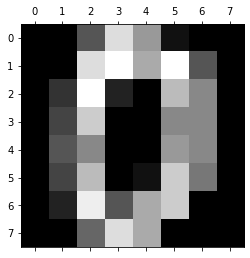

In [0]:
plt.gray()
plt.matshow(X_data[0,:,:])
plt.show()

In [0]:
def sample_data(n):
  """ Samples n images from the mnist dataset
      This function can easily be adapted if we want to use colored images (with 3 channels)
      -------
      Params : 
      n : int, number of images to sample on the MNIST dataset
      ------
      Returns : 
      Array of shape (n, 28, 28, 1) containing n images of shape (28,28,1)
  """
  return X_data[np.random.choice(range(len(X_data)), n), :, :, np.newaxis]

# Optimal Transport GAN


Generative adversarial nets or GANs (Goodfellow et al., 2014) are made of two main components : A generator $g$ and a discriminator $d$.
The generator maps noise $z$ to simulated images $y = g(z)$. The discriminator tries to distinguish simulated images $y$ from real images $x$ drawn from the distribution of training data $p$. The discriminator is rewarded for being able to accurately discriminate between fake and real samples. The generator is rewarded for fooling the discriminator. This can be seen as a game between $g$ and $d$. This game has an equilibrium which we want to find during training. If $(g,d)$ is an equilibrium to this game (here, equilibrium must be understood in the game theory sense, that is Nash equilibrium), then the generator minimizes its loss which is defined by :
$$L_g = \sup_d
\mathbb{E}_{x \sim p} log[d(x)] + \mathbb{E}_{y \sim g} log[1 − d(y)] 
$$


Researchers have investiguated the link that exists between GANs optimization and optimal transport, the main idea being that a good objective for the generator would be to minimize the distance between the probability distribution of the training data and that of $g(z)$. Defining a good distance for this problem is where the optimal transport theory gave very interesting perspectives. Indeed, the Earth Mover distance was proved to be a very good distance for this task (Arjovsky et al. (2017)). The Earth Mover distance (EMD) between two probability distribution $p$ and $g$ is defined as follows : 
$$
D_{EMD}(p, g) = inf_{\gamma \in \Pi (p,g)} \mathbb{E}_{x,y \sim γ} c(x, y),
$$

where $Π(p,g)$ represent the set of all joint distributions $γ(x, y)$ with marginal distribution $p(x)$ and $g(y)$ and $c$ is some distance function. While this distance is very useful in theory, it is not directly usable in practice because of obvious computational issues. To overcome this, a regularized version of this distance (sinkhorn distance) is usually used (Cuturi 2013) : 
$$
D_{sinkhorn}(p, g) = inf_{\gamma \in \Pi_\beta(p,g)} \mathbb{E}_{x,y \sim γ} c(x, y),
$$

where $$Π_\beta(p,g)$$ is the same set as before but restrited to joint distribution with entropy of at least some constant $β$.

As the authors report, this distance has been approximated in the litterature by evaluating it on mini batches of data. Consider $X = [x_1, \dots, x_K]$ and $Y = [y_1, \dots, y_K]$, two mini batches of data. One then build a cost matrix $C$ where $C_{i,j} = c(x_i, y_j)$. The joint distribution $\gamma$ is replaced by a matrix $M$ of size $K \times K$ which matches points from $X$ to $Y$ (soft matching matrix), with all rows and columns summing to 1. The regularization applies to the set of matrices $\mathcal{M}$ we consider to find $M$ by requiring that $− Tr[Mlog(M^T)] ≥ α$. Using this, the distance evaluated on the minibatches $X$ and $Y$ becomes : 
$$ 
W_c(X, Y ) = inf_{M∈ \mathcal{M}}Tr[MC^T].
$$ 

This formula gives a block for the final metric that is optimized in the OT GAN algorithm. In practice, in can be efficiently computed using the Sinkhorn algorithm.



Based on this way of computing distance between minibatches of data, several losses to optimize have been proposed in the litterature. In this paper the authors propose the following one (Minibatch energy distance) : 

$$
D^2_{MED}(p, g) = 2 \cdot E[W_c(X, Y)] − E[W_c(X, X')] − E[W_c(Y, Y')],
$$

where where $X, X'$ are independently sampled mini-batches from distribution $p$ and $Y, Y'$ are independent mini-batches sampled from $g$. The authors argue that the adding the repulsive term $-E[W_c(Y, Y')]$ makes the resulting mini-batch gradients unbiased and the objective statistically consistent. 

Intuitively, by looking at this formula, we can see that if we want to minimize this distance, it means that we want our distributions $p$ and $g$ to be close while ensuring that the one we are optimizing one (that the one we are modifying over the iterations, $p$) is *rich* enough. This last part is cause by the repulsive term $− E[W_c(X, X')]$. Therefore, $p$ is pushed towards $g$ and towards being as rich and diverse as $g$ is.


**OT GAN algorithm**

Now we have all the theoritical parts and blocks needed to present the OT GAN algorithm introduced in the referenced paper. 
The idea of the algortihm is the following. \\

Let us consider, a generator function $g$ which maps some fixed-distribution random noise $z$ to an image. Here, $z$ is follows $100$-dimensionnal uniform distribution on $[-1, 1]$ and the images that $g$ outputs are of shape (28,28,1) because of our particular application to the MNIST dataset. We also have a discriminator $d$ which maps an image (here of shape (28,28,1)) to a vector in $\mathbb{R}^p$.

We can notice that the discriminator no longer outputs a probability but a **latent space** which its going to learn. To simplify notation, let's say that at any step, the generator samples from a distribution $G$ (which changes as we update the generator) and we denote by $T$ the distribution of the training data. Sampling from $G$ simply means sampling $z$ from $U([-1,1]^{100})$ and then applying $g(z)$.

An iteration of the algorithm can be described as follows : 

1.   Two samples X, X' are independently drawn from $G$ and Y, Y' from $T$
2.   Apply the discriminator to X, X', Y, Y' and retrieve their representation in the latent space.  
3.   Use the sinkhorn algorithm to compute the softmatchings between pairs of minibatches' latent space's representations obtained in 2.
4.   Compute the loss as defined before
5.   Update generator so as to decrease the loss, update discriminator so as to increase the loss. 





Now, one function still has to be defined: the cost function. The function we want to define needs to define a cost between two **vectors** as its input will be vectors from the latent space learned by the discriminator. The authors reported that using euclidian distance did not work well and got good results using the cosine distance which is defined as : 

$$
c(u, v) = 1 − \frac{u · v}{|| u ||_2 \cdot || v ||_2}
$$
where $u$ and $v$ are two vectors from the latent space. 

We now turn to implementing this algorithm using tensorflow as automatic differentiation framework. 

In [0]:
def transport_cost(A, B):
  """ Compute the transport cost (i.e. )
      -------
      Params : 
      A : tensor of shape (latent_dim, K)
      B : tensor of shape (latent_dim, K)
      ------
      Returns : 
      tensor of shape (K, K)
      which contains all pairwise costs between vectors of A and B 
  """
  similarity = tf.reduce_sum(A[:, tf.newaxis] * B, axis=-1)
  similarity /= (tf.norm(A[:, tf.newaxis], axis=-1) * tf.norm(B, axis=-1) +1e-12)
  distance = 1 - similarity
  return distance

In [0]:

def sinkhorn(C, n, epsilon=0.01, max_iters=500):
    """ Run Sinnkhorn's algorithm
        -------
        Params : 
        C : cost matrix 
        n : int, shape of C
        epsilon : float, regularization parameter
        max_iters : number of iterations
        ------
        Returns : 
        Soft matching matrix
    """
    
    
    # Compute the kernel matrix K
    K = tf.exp(-C/epsilon)
    a = tf.ones(n, dtype=tf.float64)
    b = tf.ones(n, dtype=tf.float64)
    # Alternate projections
    v = tf.ones(n, dtype=tf.float64)
    for _ in range(max_iters):
        u = tf.divide(a, tf.linalg.matvec(K,v))
        v = tf.divide(b, tf.linalg.matvec(K,u))
    return tf.matmul(tf.linalg.diag(u), tf.matmul(K, tf.linalg.diag(v)))

### GAN object 

Here we create a GAN object which will be used to define instances of GANs which are block of generator and discriminator. The architecture of the generator and discriminator is inspired by the one described in the paper, though not exactly the same (primarily to decrease the number of parameters and training time). 

In [0]:
class GAN(object):
  def __init__(self, color=False):
    self.n_channel = 1 #black and white images
    if color:
      self.n_channel = 3 #colored images

    #Setting up the weights and biases for the generator 
    self.W0_gen = tf.Variable(np.random.rand(784,100), shape = (784,100), trainable=True)
    self.W1_gen = tf.Variable(np.random.randn(3,3,self.n_channel,8), shape=[3,3,self.n_channel,8])
    self.W2_gen = tf.Variable(np.random.randn(3,3,8,8), shape=[3,3,8,8])
    self.W3_gen = tf.Variable(np.random.randn(3,3,8,self.n_channel), shape=[3,3,8,self.n_channel])
    self.b0_gen = tf.Variable(np.zeros((784)), shape=(784))
    self.b1_gen = tf.Variable(np.zeros((8)), shape=(8))
    self.b2_gen = tf.Variable(np.zeros((8)), shape=(8))
    self.b3_gen = tf.Variable(np.zeros((self.n_channel)), shape=(self.n_channel))

    #Setting up the weights and biases for the discriminator
    self.W1_dis = tf.Variable(np.random.randn(3,3,self.n_channel,8), shape=[3,3,self.n_channel,8])
    self.b1_dis = tf.Variable(np.zeros((8)), shape=(8))
    self.W2_dis = tf.Variable(np.random.randn(3,3,8,8), shape=[3,3,8,8])
    self.b2_dis = tf.Variable(np.zeros((8)), shape=(8))
    self.W3_dis = tf.Variable(np.random.randn(3,3,8,4), shape=[3,3,8,4])
    self.b3_dis = tf.Variable(np.zeros((4)), shape=(4))


  def generator(self, z):
    """ 
        Generator block for the GAN of architecture : 

        - Linear transform
        - Reshape in shape (sample, 28, 28, n_channels)
        - Convolution Layer, 8 filters (3, 3, n_channels), stride = 1, padding same
        - Add bias
        - Leaky Relu non linearity
        - Convolution Layer, 8 filters (3, 3, 8), stride = 1, padding same  
        - Add bias
        - Leaky Relu non linearity
        - Convolution Layer, n_channels filters (3, 3, 8), stride = 1, padding same 
        - Add bias
        - Relu non linearity
        - L2 normalize

        ------------
        Params : 
        z : tensor of shape (n, 100)
        ------------
        Returns :
        tensor of shape (n, 28, 28, n_channels)
    """
    n = z.shape[0]
    Z0 = tf.linalg.matvec(self.W0_gen, z) + self.b0_gen
    Z0 = tf.reshape(Z0, shape=(n, 28, 28, self.n_channel))
    Z1 = tf.nn.conv2d(Z0, self.W1_gen, strides=[1,1,1,1], padding='SAME')
    Z1 = tf.nn.bias_add(Z1, self.b1_gen)
    A1 = tf.nn.leaky_relu(Z1)
    Z2 = tf.nn.conv2d(A1, self.W2_gen, strides=[1,1,1,1], padding='SAME')
    Z2 = tf.nn.bias_add(Z2, self.b2_gen)
    A2 = tf.nn.leaky_relu(Z2)
    Z3 = tf.nn.conv2d(A2, self.W3_gen, strides=[1,1,1,1], padding='SAME')
    Z3 = tf.nn.bias_add(Z3, self.b3_gen)
    A3 = tf.nn.relu(Z3)
    A4 = tf.math.l2_normalize(A3) #here we could instead use a tanh activation and then transform the values so that they fall in [0, 1]
    return A4
  
  def discriminator(self, x):
    """ 
        Discriminator block for the GAN of architecture : 

        - Convolution Layer, 8 filters (3, 3, n_channels), stride = 1, padding = same
        - Add bias
        - cRelu non linearity
        - Convolution Layer, 8 filters (3, 3, 8), stride = 2, padding = same
        - Add bias
        - cRelu non linearity
        - UpSampling layer, factor (2, 2)
        - Convolution Layer, 4 filters (3, 3, 8), stride = 2, padding = same  
        - Add bias
        - cRelu non linearity
        - UpSampling layer, factor (2, 2)
        - Reshaping 
        - L2 normalize

        ------------
        Params : 
        z : tensor of shape (n, 100)
        ------------
        Returns :
        tensor of shape (n, 28, 28, n_channels)
    """
    Z1 = tf.nn.conv2d(x, self.W1_dis, strides=[1,1,1,1], padding='SAME')
    Z1 = tf.nn.bias_add(Z1, self.b1_dis)
    A1 = tf.nn.crelu(Z1)
    Z2 = tf.nn.conv2d(A1, self.W2_dis, strides=[1,2,2,1], padding='SAME')
    Z2 = tf.nn.bias_add(Z2, self.b2_dis)
    A2 = tf.nn.crelu(Z2)
    D2 = tf.keras.layers.UpSampling2D(size=(2, 2))(A2) 
    Z3 = tf.nn.conv2d(D2, self.W3_dis, strides=[1,2,2,1], padding='SAME')
    Z3 = tf.nn.bias_add(Z3, self.b3_dis)
    A3 = tf.nn.crelu(Z3)
    U3 = tf.keras.layers.UpSampling2D(size=(2, 2))(A3) 
    sh = U3.get_shape().as_list()
    A4 = tf.reshape(U3, shape=(sh[0], np.product(sh[1:]))) #flattening in shape (n_sample, shape)
    A5 = tf.math.l2_normalize(A4)
    return A5

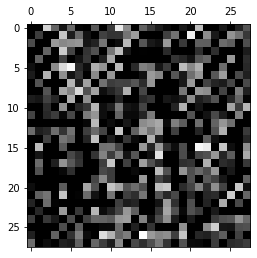

In [0]:
#create an instance of GAN and sample an image from the generator
gan = GAN()
img_ex = gan.generator(np.random.uniform(-1, 1, (1, 100)))
plt.matshow(img_ex.numpy()[0,:,:,0])
plt.show()

In [0]:
optimizer = tf.keras.optimizers.Adam() # We will use Adam optimizer as is done in the paper.

In [0]:
def train_ot_gan(model, n_iter, opt, batch_size=128):
  """ Train a GAN with the OT GAN algorithm
        -------
        Params : 
        model : GAN object
        n_iter : int, number of iteration of the algorithm
        opt : tensorflow optimizer (or customed)
        batch_size : int, size of minibatches to sample
        ------
        Returns : 
        None
        The model in modified in place.
    """
  losses = [] #Storing losses to monitor iterations
  for it in range(n_iter):
    #sample two minibatches independently from the training data
    xr = sample_data(batch_size) #X
    xrp = sample_data(batch_size) #X'

    with tf.device('/device:GPU:0'): 
      
      with tf.GradientTape(persistent=True) as t:
        #Sample independently two minibatches of generated images
        xn = model.generator(np.random.uniform(-1, 1, (batch_size, 100))) #Y
        xnp = model.generator(np.random.uniform(-1, 1, (batch_size, 100))) #Y'
        
        #Passing all minibatches (generated and real data) through the discriminator
        #to get their representation in the learned latent space
        feat_xr = model.discriminator(xr)
        feat_xrp = model.discriminator(xrp)
        feat_xn = model.discriminator(xn)
        feat_xnp = model.discriminator(xnp)

        #Computing the cost matrices
        C_xr_xn = transport_cost(feat_xr, feat_xn) 
        C_xr_xnp = transport_cost(feat_xr, feat_xnp) 
        C_xrp_xn = transport_cost(feat_xrp, feat_xn) 
        C_xrp_xnp = transport_cost(feat_xrp, feat_xnp) 
        C_xr_xrp = transport_cost(feat_xr, feat_xrp)
        C_xn_xnp = transport_cost(feat_xn, feat_xnp) 

        #Using Sinkhorn algorithm to compute the softmatching matrices
        M_xr_xn = sinkhorn(C_xr_xn, batch_size)
        M_xr_xnp = sinkhorn(C_xr_xnp, batch_size)
        M_xrp_xn = sinkhorn(C_xrp_xn, batch_size)
        M_xrp_xnp = sinkhorn(C_xrp_xnp, batch_size)
        M_xr_xrp = sinkhorn(C_xr_xrp, batch_size)
        M_xn_xnp = sinkhorn(C_xn_xnp, batch_size)

        #finally, compute the loss
        loss_xr_xn = tf.trace(tf.matmul(M_xr_xn, tf.transpose(C_xr_xn)))
        loss_xr_xnp = tf.trace(tf.matmul(M_xr_xnp, tf.transpose(C_xr_xnp)))
        loss_xrp_xn = tf.trace(tf.matmul(M_xrp_xn, tf.transpose(C_xrp_xn)))
        loss_xrp_xnp = tf.trace(tf.matmul(M_xrp_xnp, tf.transpose(C_xrp_xnp)))
        loss_xr_xrp = tf.trace(tf.matmul(M_xr_xrp, tf.transpose(C_xr_xrp)))
        loss_xn_xnp = tf.trace(tf.matmul(M_xn_xnp, tf.transpose(C_xn_xnp)))

        total_loss = loss_xr_xn + loss_xr_xnp + loss_xrp_xn + loss_xrp_xnp - 2 * loss_xr_xrp - 2 * loss_xn_xnp 


      #We will update the generator more frequently than the discriminator as detailed in the paper
      #for stability reasons.
      var_gen = [model.W1_gen, model.b1_gen, model.W2_gen, model.b2_gen, 
                 model.W3_gen, model.b3_gen, model.W0_gen, model.b0_gen]
      var_dis = [model.W1_dis, model.W2_dis, model.W3_dis, model.b1_dis, model.b2_dis, model.b3_dis]

      losses.append(total_loss)

      if (it+1)%4 != 0:
        #updating generator
        gradients_gen = t.gradient(total_loss, var_gen)
        optimizer.apply_gradients(zip(gradients_gen, var_gen)) 

      if (it+1)%4 == 0:
        #updating discriminator
        gradients_dis = -1*t.gradient(total_loss, var_dis)
        optimizer.apply_gradients(zip(gradients_dis, var_dis))


      if it%100 == 0 :
        #This is just for monitoring the algorithm
        print("Iteration : ", it, " || Sample created image :")
        img = model.generator(np.random.uniform(-1, 1, (1, 100)))
        plt.matshow(img.numpy()[0, :, :, 0])
        plt.show()
        print("-----------")
        plt.plot(losses)
        plt.show()
        print("-----------")
  return model

In [0]:
gan = GAN()
img_ex = gan.generator(np.random.uniform(-1, 1, (1, 100)))
plt.matshow(img_ex.numpy()[0,:,:,0])
plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration :  0  || Sample created image :


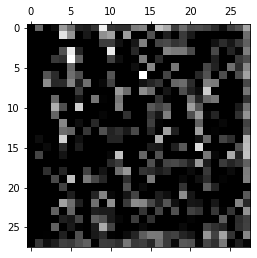

-----------


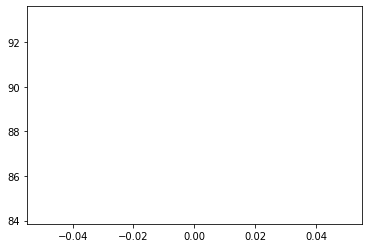

-----------
Iteration :  100  || Sample created image :


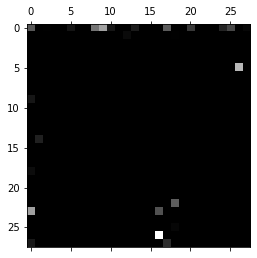

-----------


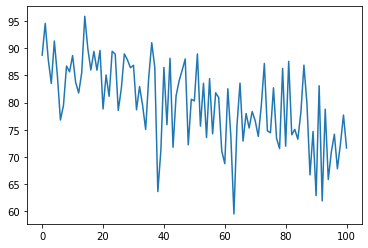

-----------
Iteration :  200  || Sample created image :


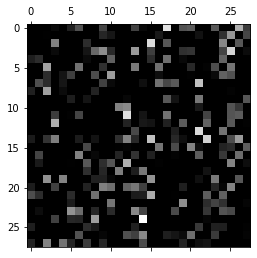

-----------


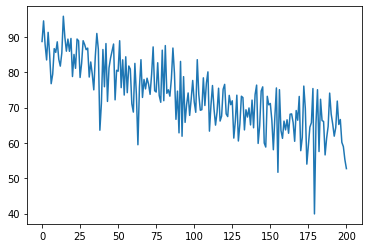

-----------
Iteration :  300  || Sample created image :


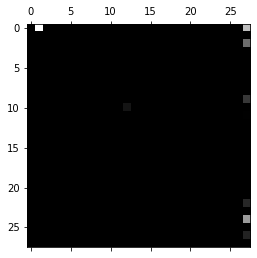

-----------


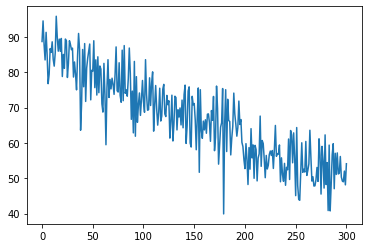

-----------
Iteration :  400  || Sample created image :


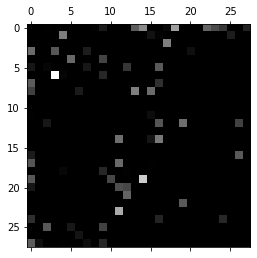

-----------


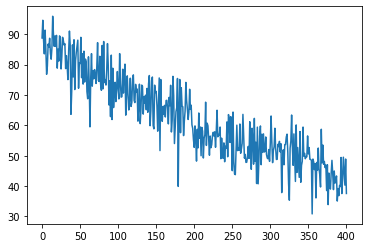

-----------
Iteration :  500  || Sample created image :


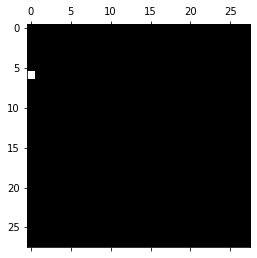

-----------


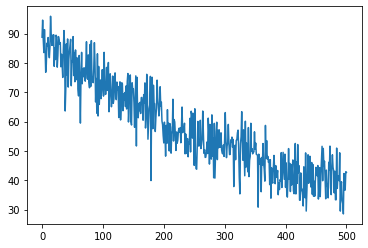

-----------
Iteration :  600  || Sample created image :


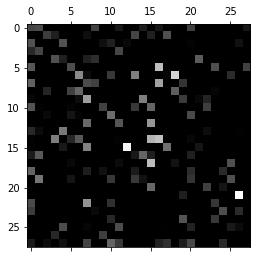

-----------


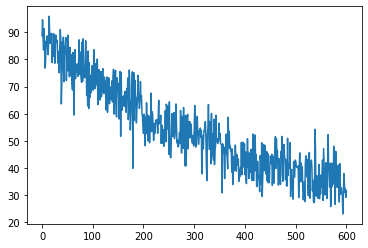

-----------
Iteration :  700  || Sample created image :


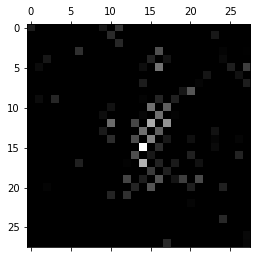

-----------


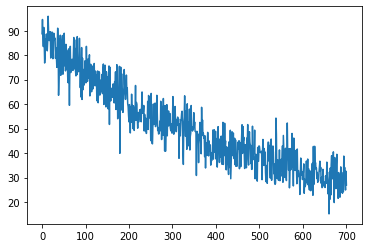

-----------
Iteration :  800  || Sample created image :


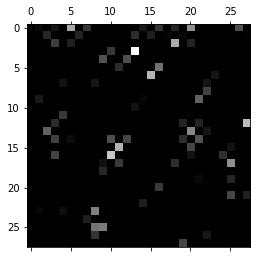

-----------


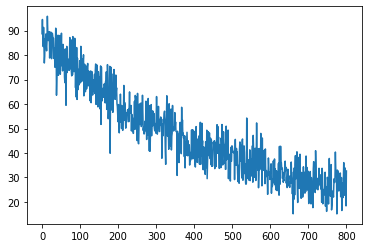

-----------
Iteration :  900  || Sample created image :


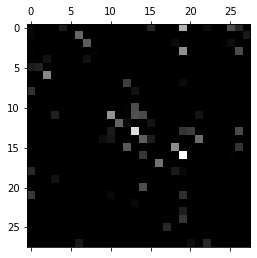

-----------


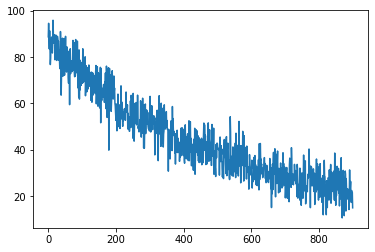

-----------
Iteration :  1000  || Sample created image :


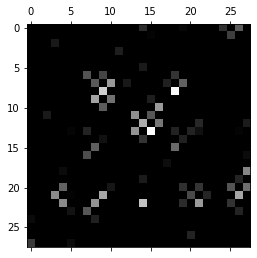

-----------


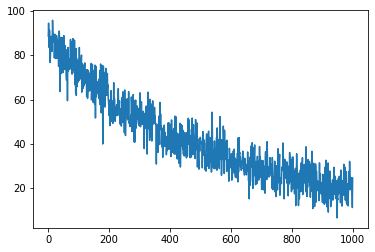

-----------
Iteration :  1100  || Sample created image :


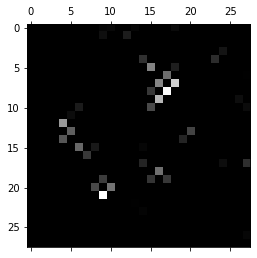

-----------


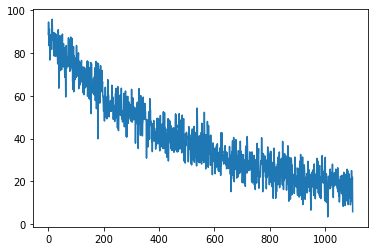

-----------
Iteration :  1200  || Sample created image :


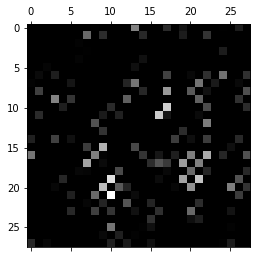

-----------


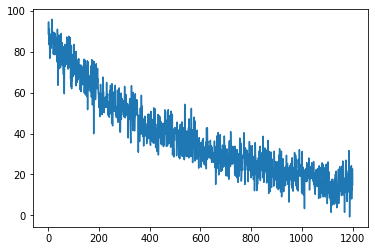

-----------
Iteration :  1300  || Sample created image :


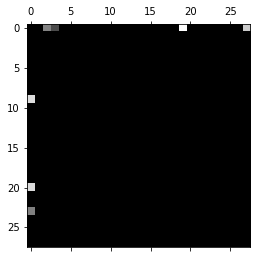

-----------


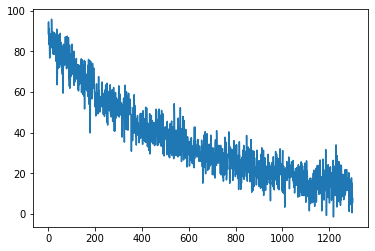

-----------
Iteration :  1400  || Sample created image :


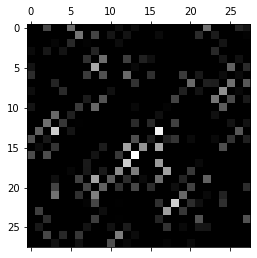

-----------


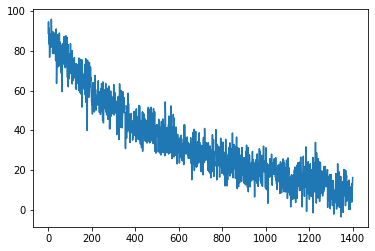

-----------
Iteration :  1500  || Sample created image :


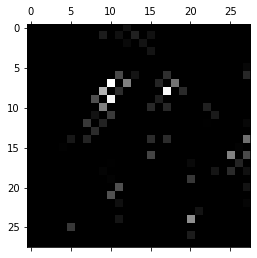

-----------


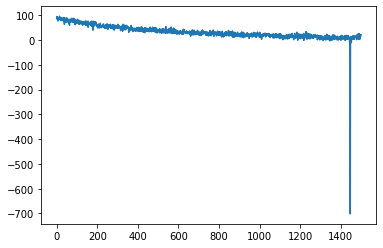

-----------
Iteration :  1600  || Sample created image :


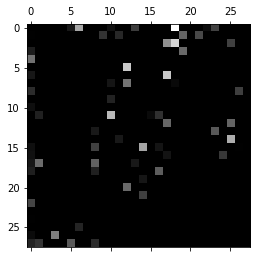

-----------


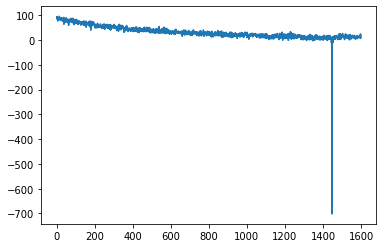

-----------
Iteration :  1700  || Sample created image :


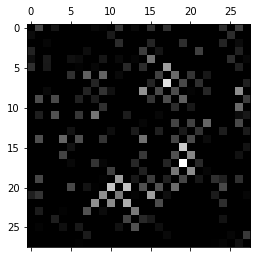

-----------


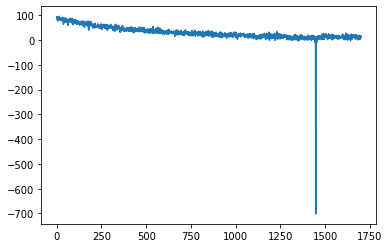

-----------
Iteration :  1800  || Sample created image :


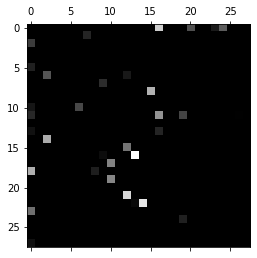

-----------


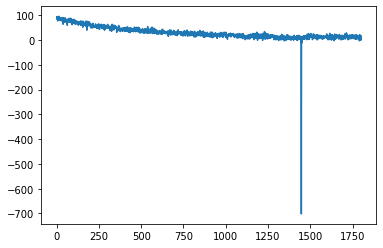

-----------
Iteration :  1900  || Sample created image :


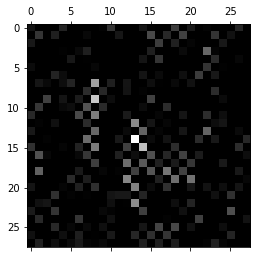

-----------


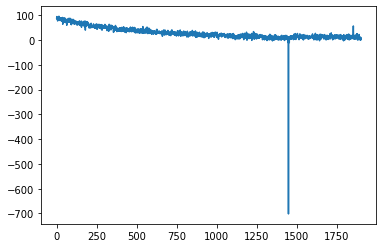

-----------


In [0]:
gott = train_ot_gan(gan, 2000, optimizer, batch_size=100)

Iteration :  0  || Sample created image :


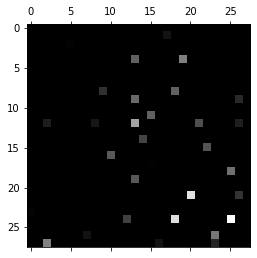

-----------


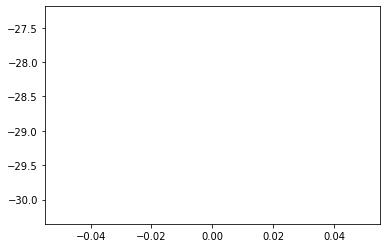

-----------
Iteration :  100  || Sample created image :


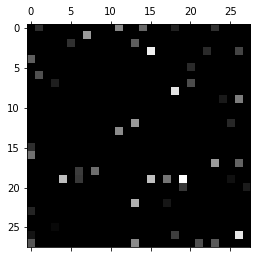

-----------


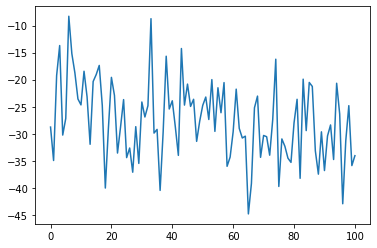

-----------
Iteration :  200  || Sample created image :


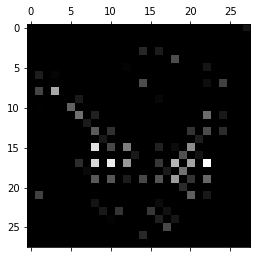

-----------


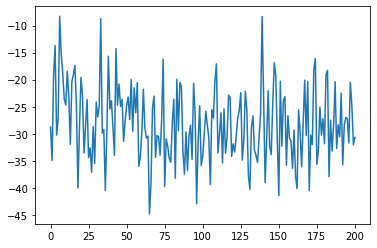

-----------
Iteration :  300  || Sample created image :


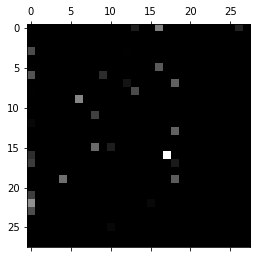

-----------


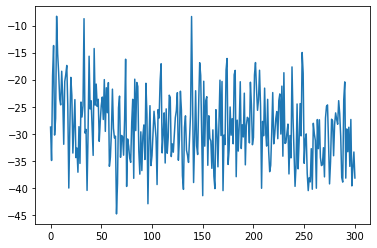

-----------
Iteration :  400  || Sample created image :


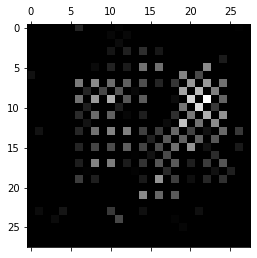

-----------


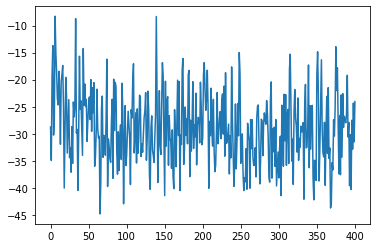

-----------
Iteration :  500  || Sample created image :


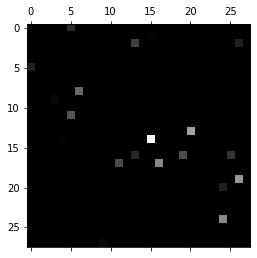

-----------


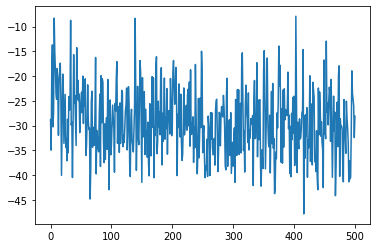

-----------
Iteration :  600  || Sample created image :


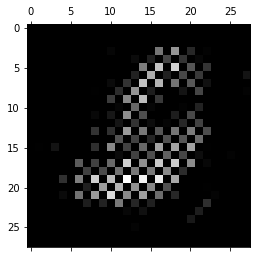

-----------


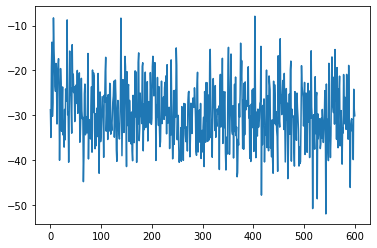

-----------
Iteration :  700  || Sample created image :


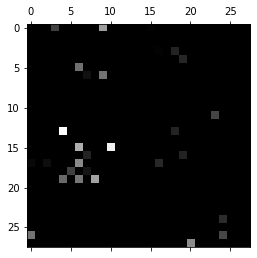

-----------


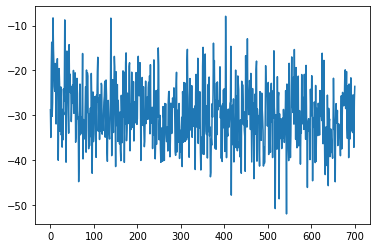

-----------
Iteration :  800  || Sample created image :


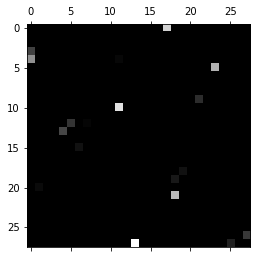

-----------


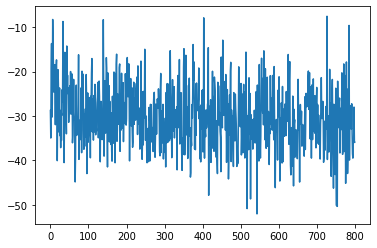

-----------
Iteration :  900  || Sample created image :


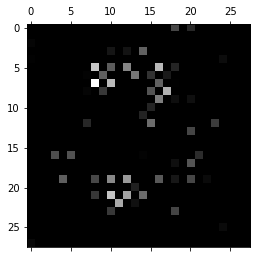

-----------


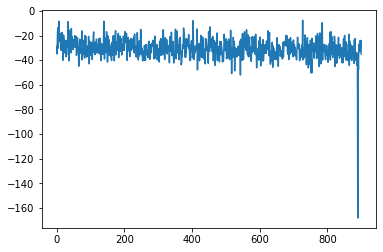

-----------
Iteration :  1000  || Sample created image :


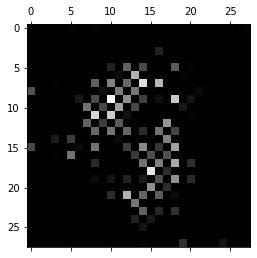

-----------


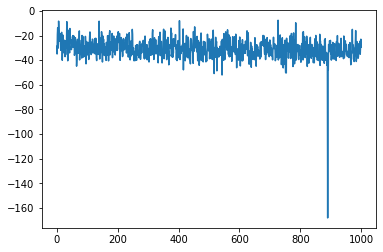

-----------


In [0]:
gott = train_ot_gan(gan, 1001, optimizer, batch_size=100) #For instability reasons (in the colab environment), I could not launch the previous cells with a large number of iterations
#hence, this cell which was runned several times

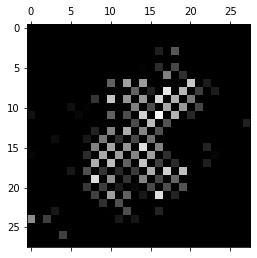

In [0]:
img_ex = gan.generator(np.random.uniform(-1, 1, (1, 100)))
plt.matshow(img_ex.numpy()[0,:,:,0])
plt.show()

# Results & Conclusion

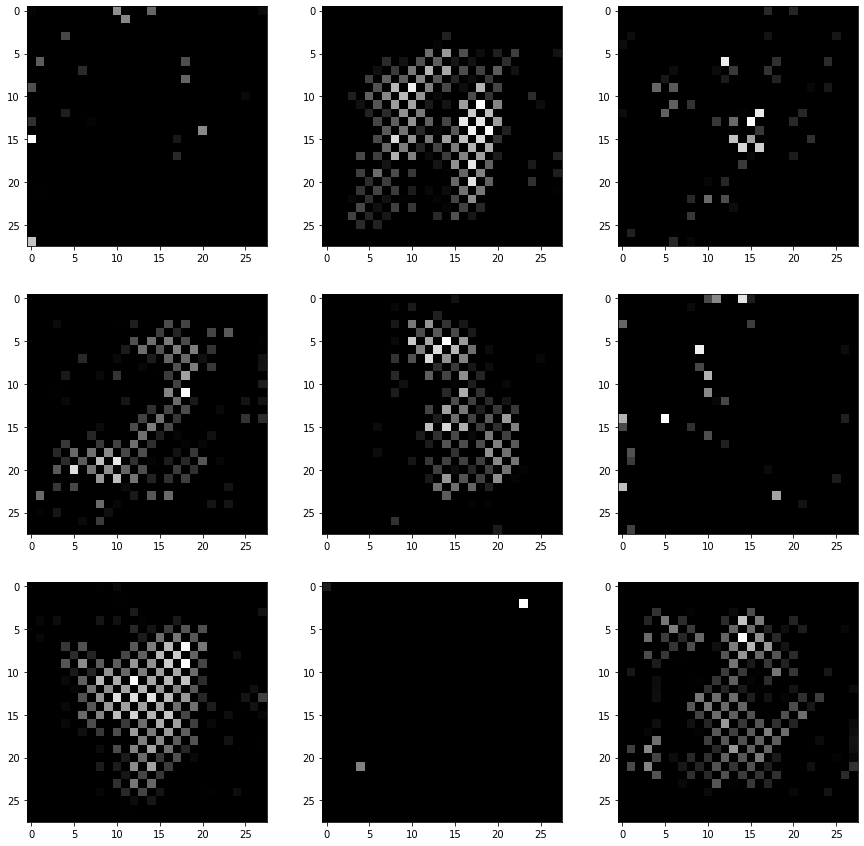

In [0]:
f, axarr = plt.subplots(3,3, figsize=(15,15))
axarr[0,0].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[0,1].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[1,0].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[1,1].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[0,2].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[1,2].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[2,0].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[2,1].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
axarr[2,2].imshow(gan.generator(np.random.uniform(-1, 1, (1, 100))).numpy()[0,:,:,0])
plt.show()

After training the model, if we generate several images, we can on this sample distinguish a 2, a 3 and a 4. We also see that some of the generated images don't make sense. Their can be several reasons for this, first of all the model was not probably not trained long enough (because of instability reasons and lack of offline computational power), secondly the architecture of the generator and discriminator might not be the best ones. Indeed, they should be tuned to improve performance. The minibatch size in the paper was set to 200 and the authors reported the best performance and stability with this size, however, this could not be done here because of memory issue (memory issue could be due to non-optimal coding from my part).
To improve performance, we could also review the weights initialisation which is simply following a standard normal distribution (e.g. use Xavier init, or following a N(0,0.002) as advised in the DCGAN paper). 

As for the running time which was quite important (10 minutes per 100 iterations, i.e. approximately 1.5 epochs), this might be improved with better coding.

Overall, considering the relatively short training time, the trained OTGAN gave somewhat satisfying results even if we still see some mode collapse as not all digits seem to be generated.


